In [8]:
import scipy.stats

import numpy as np

import matplotlib.pyplot as plt

Text(0, 0.5, 'y')

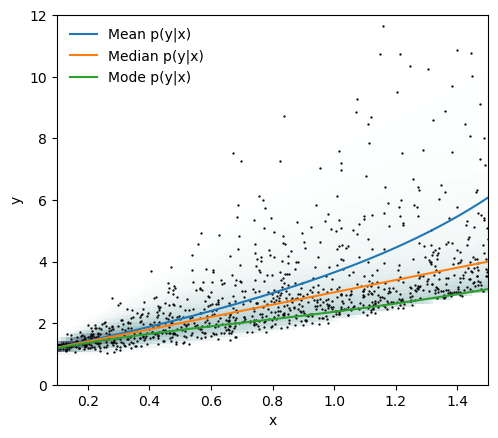

In [178]:
def distr(x):
    d =  scipy.stats.lognorm(s=x, loc=2*x)
    # Patch in mode method for log-normal distribution
    def mode(x=x):
        return np.exp(-x**2) + 2*x
    d.mode = mode
    return d  

x = np.random.uniform(0.1, 1.5, size=1000)
y = distr(x).rvs()

fig, ax = plt.subplots(1, 1)
ax.scatter(x, y, s=0.4, color="black")

x_grid = np.linspace(0.1, 1.5, 100)
ax.plot(x_grid, distr(x_grid).mean(), label="Mean p(y|x)")
ax.plot(x_grid, distr(x_grid).median(), label="Median p(y|x)")
ax.plot(x_grid, distr(x_grid).mode(), label="Mode p(y|x)")

ax.legend(frameon=False)

y_grid = np.linspace(0, 12, 100)
pdf_grid = distr(x_grid).pdf(y_grid[:,None])
ax.imshow(
    pdf_grid,
    origin="lower",
    extent=(min(x_grid), max(x_grid), min(y_grid), max(y_grid)),
    cmap="bone_r"
)
ax.set_aspect(0.1)

ax.set_xlabel("x")
ax.set_ylabel("y")

https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.html#

In [182]:
import jax
import jax.numpy as jnp

import flax.linen as nn
import optax

import tqdm


class MLP(nn.Module):
    n_hidden: int = 128
    n_output: int = 1

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=self.n_hidden)(x)
        x = nn.swish(x)
        x = nn.Dense(features=self.n_hidden)(x)
        x = nn.swish(x)
        x = nn.Dense(features=self.n_output)(x)
        return x


def get_batch(n=64):
    x = np.random.uniform(0.1, 1.5, size=(n, 1))
    y = distr(x).rvs()
    return x, y
	
def L2_loss_fn(params, model, x, y):
    predictions = model.apply(params, x)

    mse = (predictions - y)**2
    return jnp.mean(mse)

def L1_loss_fn(params, model, x, y):
    predictions = model.apply(params, x)

    return jnp.mean(jnp.abs(predictions - y))

def train(model, loss_fn):
    x, y = get_batch()
    params = model.init(jax.random.PRNGKey(0), x)

    optimizer = optax.adam(learning_rate=0.001)
    opt_state = optimizer.init(params)

    @jax.jit
    def update_model(params, opt_state, x, y):
        # Computes the gradients of the model
        loss, grads = jax.value_and_grad(loss_fn)(params, model, x, y)

        # Computes the weights updates and apply them
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)

        return params, opt_state, loss

    progress = tqdm.tqdm(range(10000))
    for i in progress:
        # Get a batch of data
        x, y = get_batch(n=512)

        # Apply the update function
        params, opt_state, loss = update_model(params, opt_state, x, y)

        if i % 100 == 0:
            progress.set_postfix({"loss": loss})
    
    return params, loss


model = MLP()

params, loss = train(model, L2_loss_fn)
L2_trained_model = model.bind(params)

params, loss = train(model, L1_loss_fn)
L1_trained_model = model.bind(params)




  0%|          | 0/10000 [00:00<?, ?it/s]/Users/yooken/Codes/mambaforge/envs/stats_course/lib/python3.11/site-packages/flax/core/scope.py:600: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/Users/yooken/Codes/mambaforge/envs/stats_course/lib/python3.11/site-packages/flax/core/scope.py:601: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)
100%|██████████| 10000/10000 [00:13<00:00, 745.95it/s, loss=0.9642828]


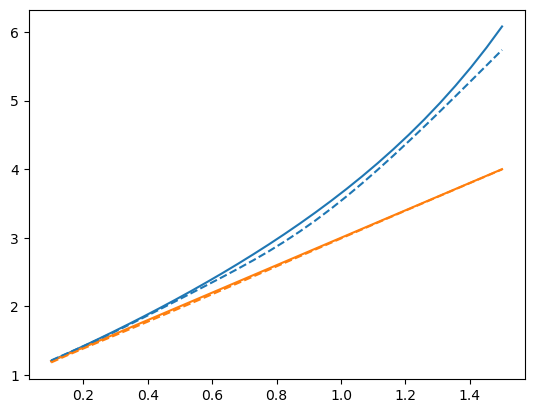

In [184]:
x_test = jnp.linspace(0.1, 1.5, 30)
mean_y_test = distr(x_test).mean()
median_y_test = distr(x_test).median()
mode_y_test = distr(x_test).mode()

L2_predictions_test = L2_trained_model(x_test[:, None])
L1_predictions_test = L1_trained_model(x_test[:, None])

plt.plot(x_test, mean_y_test)
plt.plot(x_test, median_y_test)
# plt.plot(x_test, mode_y_test)

plt.plot(x_test, L2_predictions_test, ls="--", c="C0")
plt.plot(x_test, L1_predictions_test, ls="--", c="C1")



In [229]:
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

class MDN(nn.Module):
    n_hidden: int = 128
    n_components: int = 8
    n_output: int = 1

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=self.n_hidden)(x)
        x = nn.swish(x)
        x = nn.Dense(features=self.n_hidden)(x)
        x = nn.swish(x)
        x = nn.tanh(nn.Dense(features=self.n_components)(x))
        
        categorical_logits = nn.Dense(self.n_components)(x)
        loc = nn.Dense(self.n_components)(x)
        scale = nn.softplus(nn.Dense(self.n_components)(x))

        dist = tfd.Independent(
            tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(logits=categorical_logits),
                components_distribution=tfd.Normal(loc=loc, scale=scale)
            )
        )
        
        return dist

def NLL_loss_fn(params, model, x, y):
    q = model.apply(params, x)
    nll = - q.log_prob(y[:, 0])
    return jnp.mean(nll)

model = MDN(n_components=16)

params, loss = train(model, NLL_loss_fn)
NLL_trained_model = model.bind(params)

/Users/yooken/Codes/mambaforge/envs/stats_course/lib/python3.11/site-packages/flax/core/scope.py:600: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  abs_value_flat = jax.tree_leaves(abs_value)
/Users/yooken/Codes/mambaforge/envs/stats_course/lib/python3.11/site-packages/flax/core/scope.py:601: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  value_flat = jax.tree_leaves(value)
100%|██████████| 10000/10000 [00:15<00:00, 664.89it/s, loss=1.0340481]


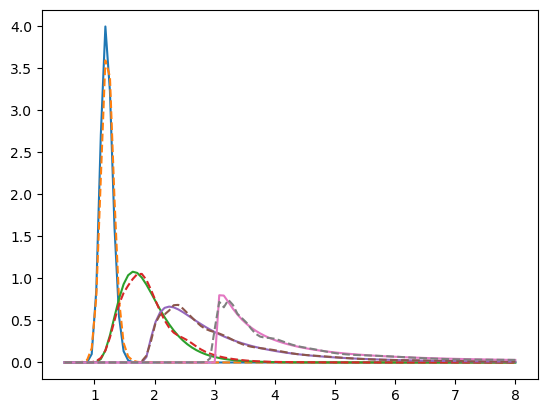

In [230]:
y_grid = np.linspace(0.5, 8, 100)

for x_test in [0.1, 0.4, 0.9, 1.5]:
    q = NLL_trained_model([x_test])
    plt.plot(y_grid, distr(x_test).pdf(y_grid))
    plt.plot(y_grid, np.exp(q.log_prob(y_grid)), ls="--")

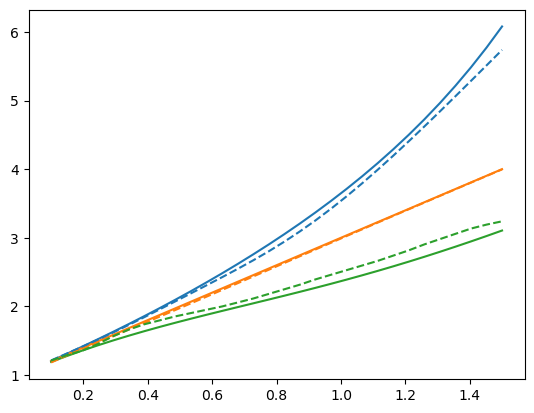

In [231]:
def mode_grid(x):
    q = NLL_trained_model(x[:, None])
    y_grid = np.linspace(0.2, 5, 500)
    log_prob = q.log_prob(y_grid[:, None])
    
    return y_grid[jnp.argmax(log_prob, axis=0)]

x_test = jnp.linspace(0.1, 1.5, 30)
mean_y_test = distr(x_test).mean()
median_y_test = distr(x_test).median()
mode_y_test = distr(x_test).mode()

L2_predictions_test = L2_trained_model(x_test[:, None])
L1_predictions_test = L1_trained_model(x_test[:, None])
NLL_predictions_test = mode_grid(x_test)

plt.plot(x_test, mean_y_test)
plt.plot(x_test, median_y_test)
plt.plot(x_test, mode_y_test)

plt.plot(x_test, L2_predictions_test, ls="--", c="C0")
plt.plot(x_test, L1_predictions_test, ls="--", c="C1")
plt.plot(x_test, NLL_predictions_test, ls="--", c="C2")
